# Import Library

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from random import shuffle
from PIL import Image
from skimage.morphology import disk
from skimage.util import img_as_ubyte
import imageio
from tqdm import tqdm
import tensorflow as tf

# Set-up path

In [2]:
data_path = 'C:/Users/sunde/Desktop/Brain Tumor'

# Define image size and batch size

In [3]:
IMG_SIZE = 512
BATCH_SIZE = 32

# Preprocess Image

In [4]:
# Define a function to preprocess the images
def preprocess_images(path):
    images = []
    labels = []
    for label, tumor_type in enumerate(['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']):
        tumor_path = os.path.join(path, tumor_type)
        for img_name in os.listdir(tumor_path):
            img_path = os.path.join(tumor_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Preprocess the training and testing images
X, y = preprocess_images(data_path)

# Convert the labels to one-hot encoding

In [6]:
y = to_categorical(y)
print(y)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# Split the data into training and validation sets

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Squential Model

In [8]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 150x150 with 3 bytescolor
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fifth convolution
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu',name='Retrieval_Layer'),
tf.keras.layers.Dense(64, activation='relu'),
# tf.keras.layers.Dense(32, activation='relu'),
# tf.keras.layers.Dense(16, activation='relu'),
tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        1

In [11]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a checkpoint to save the best model weights
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Train the model and save the history
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, use_multiprocessing=True, callbacks=[checkpoint])

# Save the entire model to a .h5 file
model.save('brain_tumor_model.h5')

# Save the training history to a .npy file
np.save('brain_tumor_history.npy', history.history)

Train on 2528 samples, validate on 632 samples
Epoch 1/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 5.3630e-04 - accuracy: 1.0000 - val_loss: 0.4099 - val_accuracy: 0.9146
Epoch 2/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 4.7464e-04 - accuracy: 1.0000 - val_loss: 0.4134 - val_accuracy: 0.9177
Epoch 3/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 4.2067e-04 - accuracy: 1.0000 - val_loss: 0.4176 - val_accuracy: 0.9161
Epoch 4/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 3.7738e-04 - accuracy: 1.0000 - val_loss: 0.4188 - val_accuracy: 0.9193
Epoch 5/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 3.4231e-04 - accuracy: 1.0000 - val_loss: 0.4244 - val_accuracy: 0.9177
Epoch 6/10
2528/2528 [==============================] - 21s 8ms/sample - loss: 3.0527e-04 - accuracy: 1.0000 - val_loss: 0.4257 - val_accuracy: 0.9177
Epoch 7/10
2528/2528 [=========================

In [9]:
import keras
model_path1 = './/brain_tumor_model.h5'
model1 = keras.models.load_model(model_path1)

# Evaluate the model on the test set

In [10]:
test_loss, test_acc = model1.evaluate(X_val, y_val)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

20/20 [==============================] - 14s 697ms/step - loss: 0.4380 - accuracy: 0.9177
Test loss: 0.4379664659500122
Test accuracy: 0.9177215099334717


# Classification Report

In [11]:
y_test_pred = np.argmax(model1.predict(X_val), axis=1)
y_test_true = np.argmax(y_val, axis=1)
print("Classification Report:\n", classification_report(y_test_true, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       203
           1       0.97      1.00      0.99       184
           2       0.94      0.91      0.93        70
           3       0.85      0.89      0.87       175

    accuracy                           0.92       632
   macro avg       0.92      0.92      0.92       632
weighted avg       0.92      0.92      0.92       632



# Sensitivity, Specificity, Accuracy

In [12]:
cm = confusion_matrix(y_test_true, y_test_pred)

# Calculate sensitivity (TPR) and specificity (TNR) for each class
tp = cm.diagonal()
fn = cm.sum(axis=1) - tp
fp = cm.sum(axis=0) - tp
tn = cm.sum() - tp - fn - fp

sensitivity = np.round(tp / (tp + fn) * 100, 2)
specificity = np.round(tn / (tn + fp) * 100, 2)
accuracy = np.round((tp + tn) / (tp + tn + fp + fn) * 100, 2)

# Print results rounded to 2 decimal places
print('Sensitivity (TPR):', sensitivity)
print('Specificity (TNR):', specificity)
print('Accuracy:', accuracy)

Sensitivity (TPR): [ 87.19 100.    91.43  88.57]
Specificity (TNR): [96.27 98.88 99.29 94.09]
Accuracy: [93.35 99.21 98.42 92.56]


# Heatmap

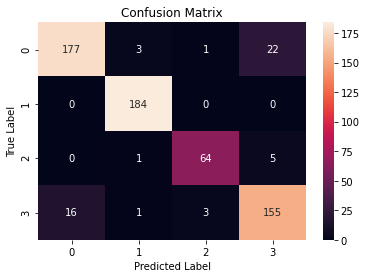

In [13]:
cm = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy and Loss

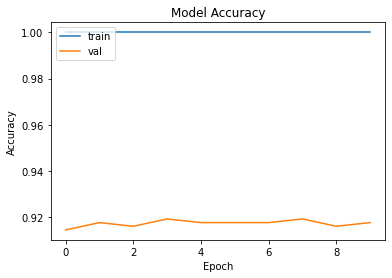

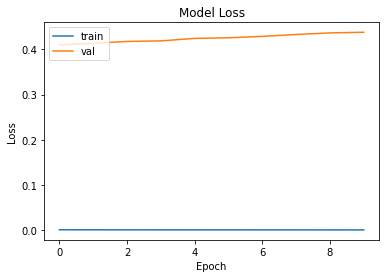

In [15]:
# Load the model
model_path1 = 'brain_tumor_model.h5'
model1 = keras.models.load_model(model_path1)

# Load the training history
history = np.load('brain_tumor_history.npy', allow_pickle=True).item()

# Plot the training and validation accuracy over time
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over time
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ROC Curve

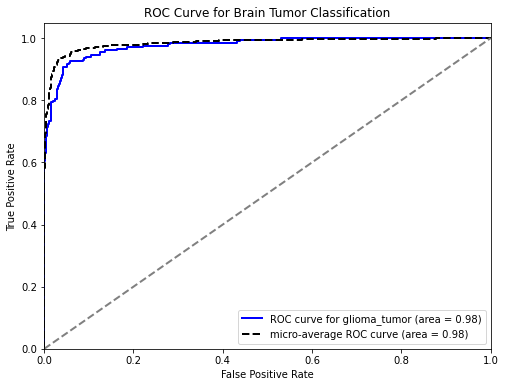

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_train and y_val to one-hot encoded binary matrix
y_train_binary = label_binarize(y_train, classes=[0, 1, 2, 3])
y_val_binary = label_binarize(y_val, classes=[0, 1, 2, 3])

# Train the model using OneVsRestClassifier
model1.fit(X_train, y_train_binary)

# Compute the predicted probabilities for each class on the validation set
y_score = model1.predict(X_val)

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_val_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label='ROC curve for glioma_tumor (area = %0.2f)' % roc_auc[0])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.show()

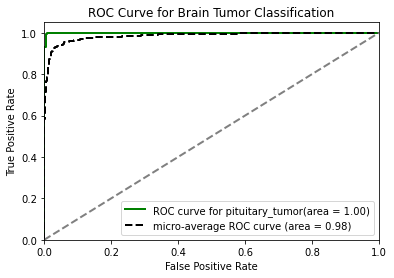

In [38]:
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='ROC curve for pituitary_tumor(area = %0.2f)' % roc_auc[1])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.show()

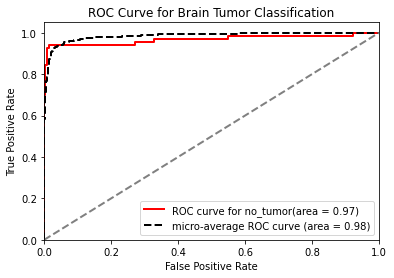

In [37]:
plt.plot(fpr[2], tpr[2], color='red', lw=2, label='ROC curve for no_tumor(area = %0.2f)' % roc_auc[2])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.show()

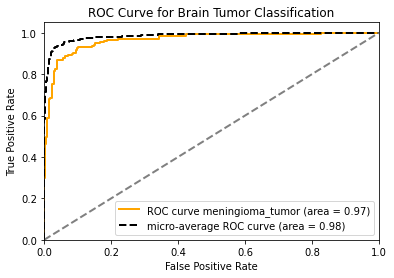

In [36]:
plt.plot(fpr[3], tpr[3], color='orange', lw=2, label='ROC curve meningioma_tumor (area = %0.2f)' % roc_auc[3])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.show()

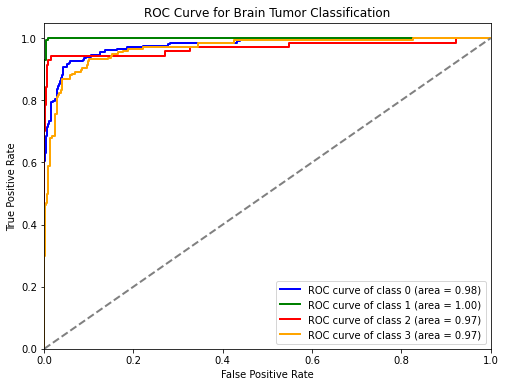

In [22]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.show()

# Bar Chart

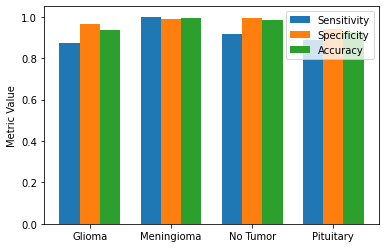

In [23]:
cm = confusion_matrix(y_test_true, y_test_pred)

# Calculate the sensitivity, specificity, and accuracy for each class
tp = np.diag(cm)
fn = cm.sum(axis=1) - tp
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (tp + fn + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Plot the bar chart
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
x = np.arange(len(classes))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sensitivity, width, label='Sensitivity')
rects2 = ax.bar(x, specificity, width, label='Specificity')
rects3 = ax.bar(x + width, accuracy, width, label='Accuracy')
ax.set_ylabel('Metric Value')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.show()

# Precision-Recall Curve

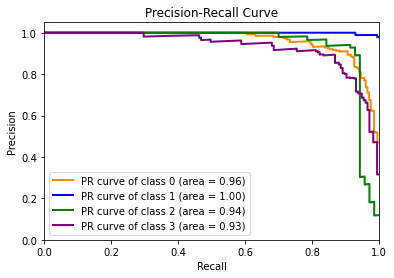

In [25]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

# Fit label binarizer to test labels
lb.fit(y_val)

# Generate precision-recall curve and calculate AUC score
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(len(lb.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot precision-recall curve
plt.figure()
colors = ['darkorange', 'blue', 'green', 'purple']
for i, color in zip(range(len(lb.classes_)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(lb.classes_[i], pr_auc[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

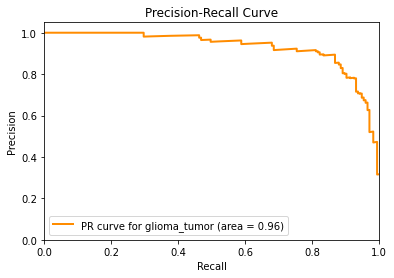

In [35]:
plt.figure()
plt.plot(recall[i], precision[i], color='darkorange', lw=2, label='PR curve for glioma_tumor (area = {1:0.2f})'
             ''.format(lb.classes_[0], pr_auc[0]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

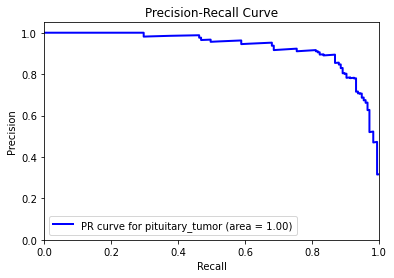

In [34]:
plt.figure()
plt.plot(recall[i], precision[i], color='blue', lw=2, label='PR curve for pituitary_tumor (area = {1:0.2f})'
             ''.format(lb.classes_[1], pr_auc[1]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

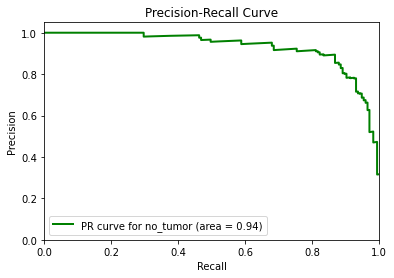

In [32]:
plt.figure()
plt.plot(recall[i], precision[i], color='green', lw=2, label='PR curve for no_tumor (area = {1:0.2f})'
             ''.format(lb.classes_[2], pr_auc[2]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

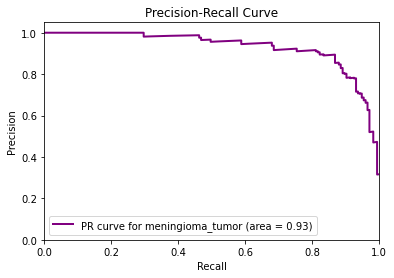

In [33]:
plt.figure()
plt.plot(recall[i], precision[i], color='purple', lw=2, label='PR curve for meningioma_tumor (area = {1:0.2f})'
             ''.format(lb.classes_[3], pr_auc[3]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()